In [1]:
import scanpy as sc
import scFates as scf

In [2]:
adata=sc.read_10x_mtx("filtered/BT400.filtered_gene_matrices/")

Finding overdispersed features
    computing mean and variances
    gam fitting
    found 335 over-dispersed features (0:00:01) --> added 
    .var['res'], residuals of GAM fit.
    .var['lp'], p-value.
    .var['lpa'], BH adjusted p-value.
    .var['qv'], percentile of qui-squared distribution.
    .var['highly_variable'], feature is over-dispersed.



/home/lfaure/miniconda3/envs/rapids-22.06-stable/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/lfaure/miniconda3/envs/rapids-22.06-stable/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


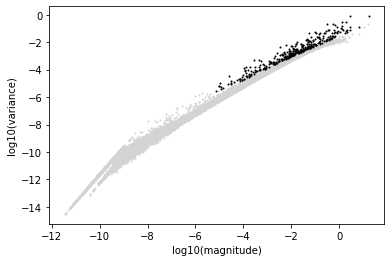

In [3]:
adata_raw=adata.copy()
sc.pp.filter_genes(adata,min_cells=1)
sc.pp.normalize_total(adata,target_sum=1e3)
sc.pp.log1p(adata)

scf.pp.find_overdispersed(adata,plot=True)

adata.raw=adata
adata=adata[:,adata.var.highly_variable]
sc.pp.scale(adata)
sc.pp.pca(adata,device="gpu")
sc.pp.neighbors(adata,method="rapids")
sc.tl.leiden(adata,flavor="rapids")
sc.tl.umap(adata,method="rapids")

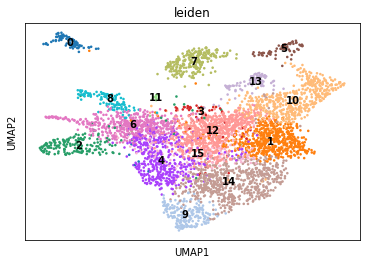

In [4]:
sc.pl.umap(adata,color="leiden",legend_loc="on data")

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.


Running Diffusion maps 
Determing nearest neighbor graph...
    determining multiscale diffusion space
    finished (0:00:02) --> added 
    .obsm['X_diffusion_multiscale'], multiscale diffusion space.


findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


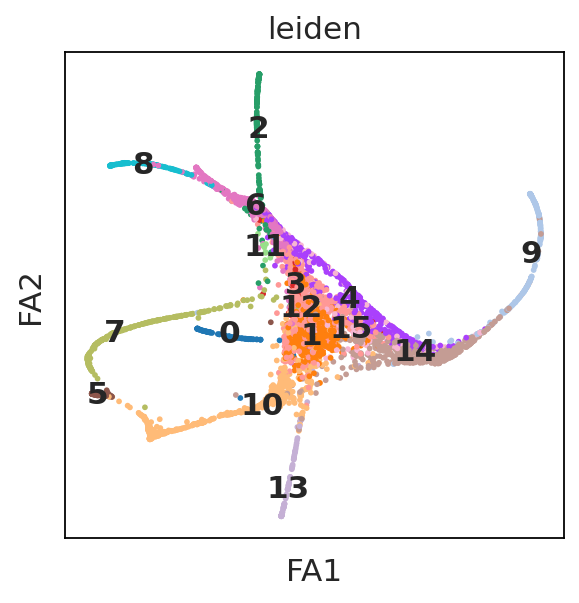

In [5]:
scf.pp.diffusion(adata)
sc.pp.neighbors(adata,use_rep="X_diffusion_multiscale")

sc.tl.draw_graph(adata,method="rapids",init_pos="X_pca")

sc.set_figure_params()
sc.pl.draw_graph(adata,color="leiden",legend_loc="on data")

In [6]:
from cellrank.tl.kernels import CytoTRACEKernel
import scvelo as scv
def get_cytotrace(adata):
    sc.pp.filter_genes(adata, min_cells=10)
    scv.pp.normalize_per_cell(adata)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata)

    adata.layers["spliced"] = adata.X
    adata.layers["unspliced"] = adata.X
    scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
    ctk = CytoTRACEKernel(adata)
    
get_cytotrace(adata_raw)

Normalized count data: X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:05) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [7]:
import scipy

In [8]:
annot=scipy.io.loadmat("annotated_cancer_data.mat")

In [9]:
annot.keys()

dict_keys(['__header__', '__version__', '__globals__', 'cancer_barcodes', 'cancer_class', 'cancer_id', 'cancer_sample', 'cgenes', 'clogm', 'phi_cancer'])

In [10]:
len(annot["cancer_class"])

30090

In [11]:
for i in range(12):
    print(len(annot["cancer_barcodes"][0][i]))

614
1404
1902
8726
5688
2400
1049
1124
586
4508
1110
979


In [12]:
from itertools import chain
allbarcodes = list(chain(*annot["cancer_barcodes"][0].tolist()))


In [13]:
import pandas as pd
df=pd.DataFrame(dict(sampl=annot["cancer_sample"].ravel(),bc=allbarcodes,cl=annot["cancer_class"].ravel()))
df.sampl=df.sampl.astype("category")
df=df.loc[df.sampl==11]
df.set_index("bc",inplace=True)
df

,sampl,cl
bc,,
AAACCTGAGCGATATA-1,11,4
AAACCTGAGGTGCACA-1,11,0
AAACCTGCAAGTTGTC-1,11,5
AAACCTGCAGACGTAG-1,11,4
AAACCTGCAGTCAGCC-1,11,4
...,...,...
TTTGTCAGTAAGGGAA-1,11,2
TTTGTCAGTGATGTGG-1,11,5
TTTGTCAGTGCCTGGT-1,11,4


In [14]:
adata.obs["cl"]=df.cl.astype("category")

In [15]:
adata.obs.cl=adata.obs.cl.cat.rename_categories(["Unassigned",
                                                 "Mesenchymal",
                                                 "Neuronal",
                                                 "Astro",
                                                 "Progenitor","Oligo"])

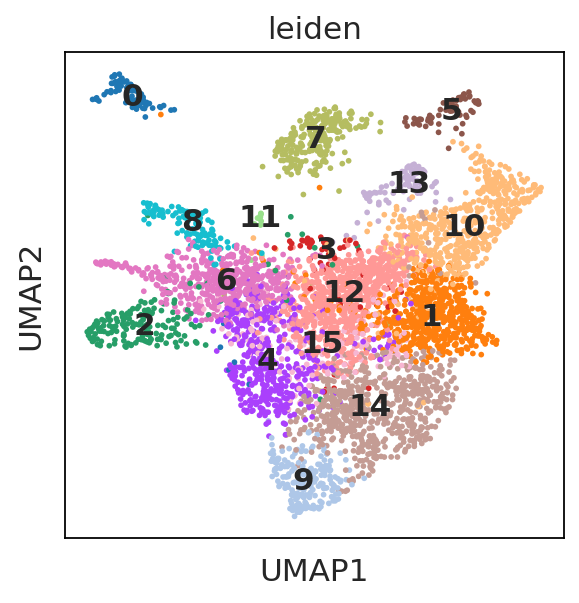

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


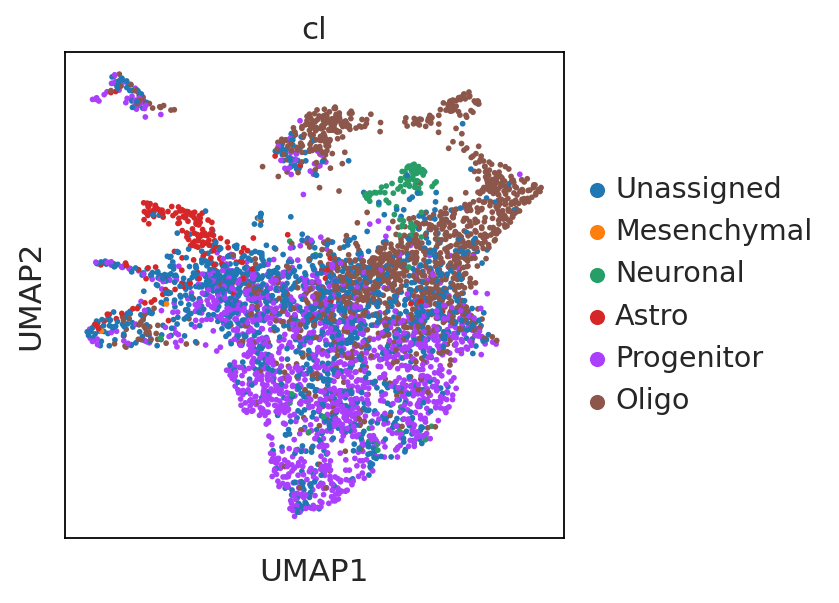

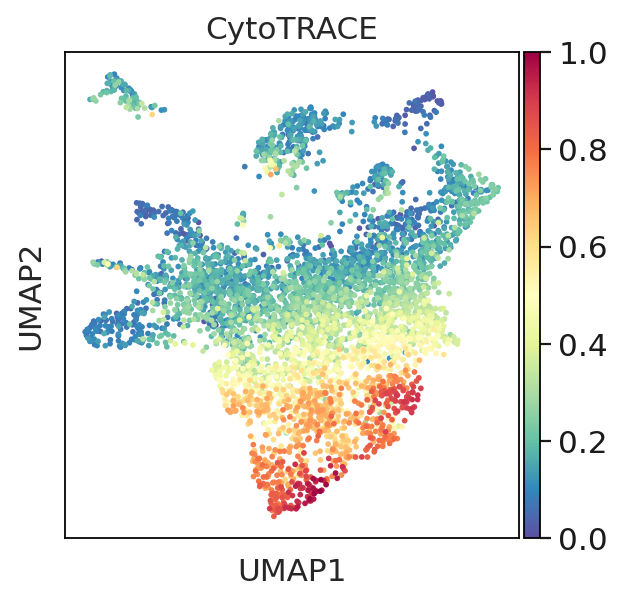

In [16]:
adata.obs["CytoTRACE"]=adata_raw.obs.ct_score
sc.pl.umap(adata,color="leiden",legend_loc='on data')
sc.pl.umap(adata,color="cl")
sc.pl.umap(adata,color="CytoTRACE",cmap="Spectral_r")

In [17]:
sc.tl.rank_genes_groups(adata,"leiden")

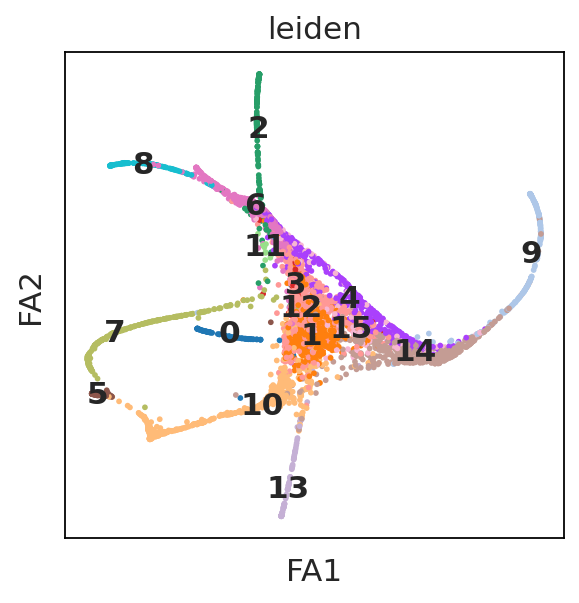

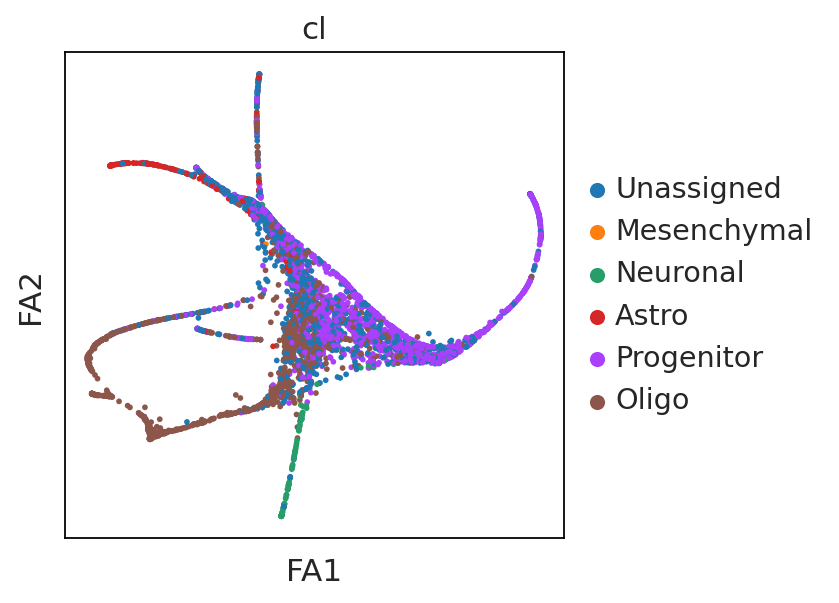

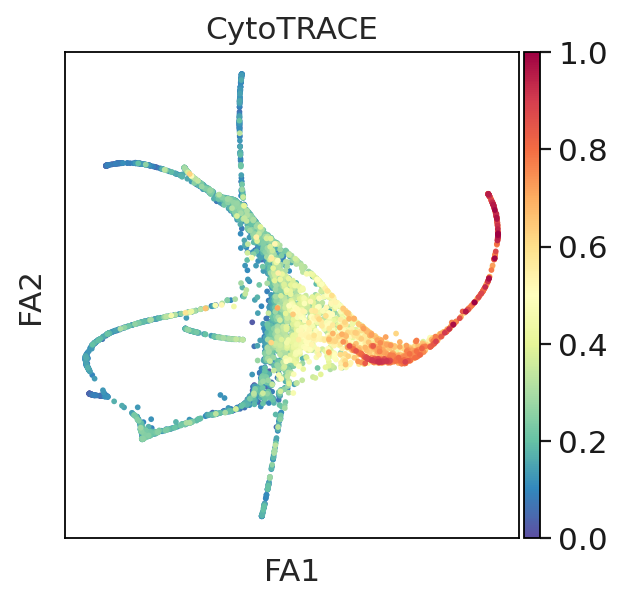

In [18]:
sc.pl.draw_graph(adata,color="leiden",legend_loc='on data')
sc.pl.draw_graph(adata,color="cl")
sc.pl.draw_graph(adata,color="CytoTRACE",cmap="Spectral_r")

In [21]:
sc.get.rank_genes_groups_df(adata,"0",log2fc_min=2)

,names,scores,logfoldchanges,pvals,pvals_adj
0,CD74,29.996830,5.844601,1.936839e-47,5.100906e-44
1,APOE,22.536160,3.938478,2.991595e-38,2.626246e-35
2,C1QB,19.505363,5.613596,2.328290e-33,1.167970e-30
3,HLA-DRA,19.238089,5.533846,6.138314e-33,3.007631e-30
4,SPP1,19.136980,5.060296,8.537537e-33,4.088122e-30
...,...,...,...,...,...
1523,ST8SIA3,0.749581,2.014203,4.555242e-01,6.085498e-01
1524,IL15RA,0.749532,2.043068,4.555003e-01,6.085498e-01
1525,SLC25A30,0.748696,2.002414,4.560705e-01,6.090480e-01
1526,ALDH1A1,0.748181,2.004141,4.563680e-01,6.094067e-01


In [22]:
sc.get.rank_genes_groups_df(adata,"7",log2fc_min=2)

,names,scores,logfoldchanges,pvals,pvals_adj
0,FIP1L1,30.256786,4.076654,9.803343e-85,1.032733e-80
1,PDGFRA,26.980885,5.625580,8.362908e-75,2.202476e-71
2,RGCC,26.259956,3.153048,5.726211e-74,1.340506e-70
3,SCFD2,19.453436,4.354232,2.113854e-51,1.535751e-48
4,HLA-C,19.354990,2.169966,7.215582e-52,5.429467e-49
...,...,...,...,...,...
1235,RP11-253M7.1,0.749158,2.014825,4.544835e-01,6.065302e-01
1236,VDR,0.745585,2.029395,4.566124e-01,6.082680e-01
1237,DDR1-AS1,0.743925,2.011801,4.576192e-01,6.091259e-01
1238,RP11-374A4.1,0.743319,2.009788,4.579839e-01,6.094895e-01


In [20]:
adata=adata[~adata.obs.leiden.isin(["7","0"])]

In [21]:
adata.write("adata_processed.h5ad")

In [22]:
scf.tl.tree(adata,Nodes=500,use_rep="X_diffusion_multiscale",method="ppt",
            seed=42,device="gpu",ppt_lambda=100)

inferring a principal tree inferring a principal tree --> parameters used 
    500 principal points, sigma = 0.1, lambda = 100, metric = euclidean
    fitting: 100%|██████████| 50/50 [00:02<00:00, 20.52it/s]
    inference not converged (error: 0.006422423861402282)
    finished (0:00:02) --> added 
    .uns['ppt'], dictionnary containing inferred tree.
    .obsm['X_R'] soft assignment of cells to principal points.
    .uns['graph']['B'] adjacency matrix of the principal points.
    .uns['graph']['F'] coordinates of principal points in representation space.


/home/lfaure/miniconda3/envs/rapids-22.06-stable/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


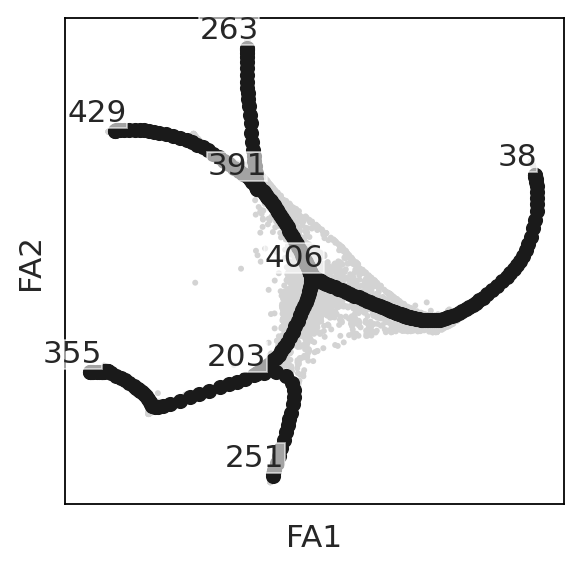

In [23]:
scf.pl.graph(adata)

In [76]:
scf.tl.root(adata,"CytoTRACE",tips_only=True)

automatic root selection using CytoTRACE values
node 38 selected as a root --> added
    .uns['graph']['root'] selected root.
    .uns['graph']['pp_info'] for each PP, its distance vs root and segment assignment.
    .uns['graph']['pp_seg'] segments network information.


In [78]:
scf.tl.pseudotime(adata,n_jobs=80,n_map=100)

projecting cells onto the principal graph
    mappings: 100%|██████████| 100/100 [00:48<00:00,  2.08it/s]
    finished (0:00:52) --> added
    .obs['edge'] assigned edge.
    .obs['t'] pseudotime value.
    .obs['seg'] segment of the tree assigned.
    .obs['milestones'] milestone assigned.
    .uns['pseudotime_list'] list of cell projection from all mappings.


In [80]:
adata=adata.raw.to_adata()

In [81]:
import numpy as np

In [82]:
adata.X.data=np.expm1(adata.X.data)

In [83]:
sc.pp.normalize_total(adata,target_sum=1e6)
sc.pp.log1p(adata,base=10)

In [84]:
scf.tl.test_association(adata,n_jobs=40)

test features for association with the trajectory
    single mapping : 100%|██████████| 21069/21069 [04:35<00:00, 76.47it/s]
    found 1700 significant features (0:04:35) --> added
    .var['p_val'] values from statistical test.
    .var['fdr'] corrected values from multiple testing.
    .var['st'] proportion of mapping in which feature is significant.
    .var['A'] amplitue of change of tested feature.
    .var['signi'] feature is significantly changing along pseudotime.
    .uns['stat_assoc_list'] list of fitted features on the graph for all mappings.


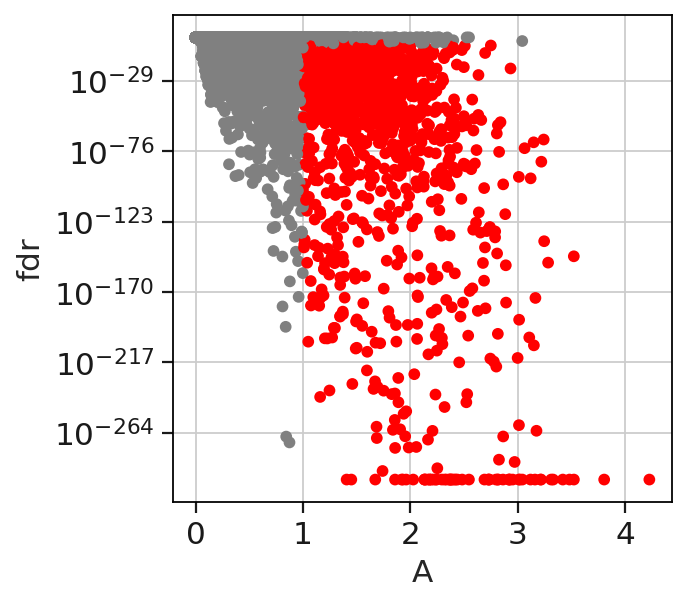

In [85]:
scf.pl.test_association(adata)

In [86]:
scf.tl.fit(adata,n_jobs=40)

fit features associated with the trajectory
    single mapping : 100%|██████████| 1700/1700 [01:04<00:00, 26.44it/s]
    finished (adata subsetted to keep only fitted features!) (0:01:07) --> added
    .layers['fitted'], fitted features on the trajectory for all mappings.
    .raw, unfiltered data.


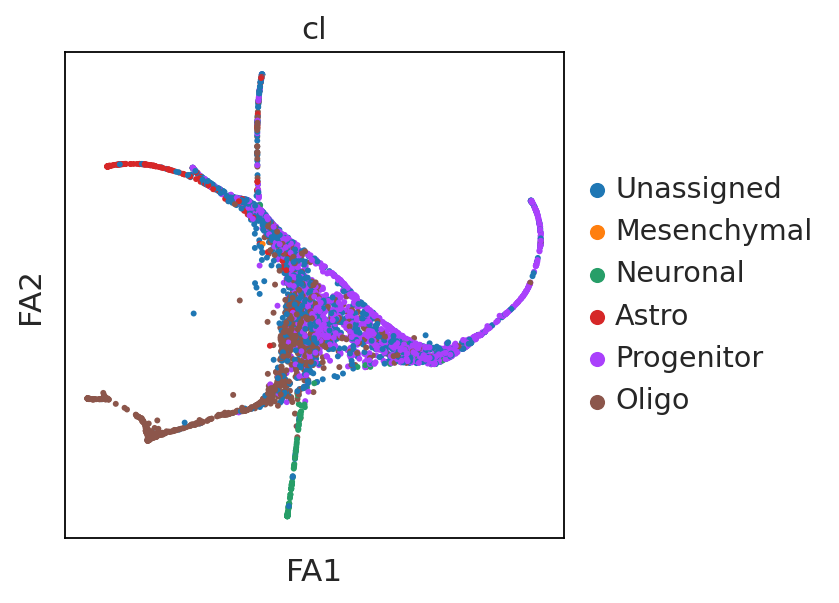

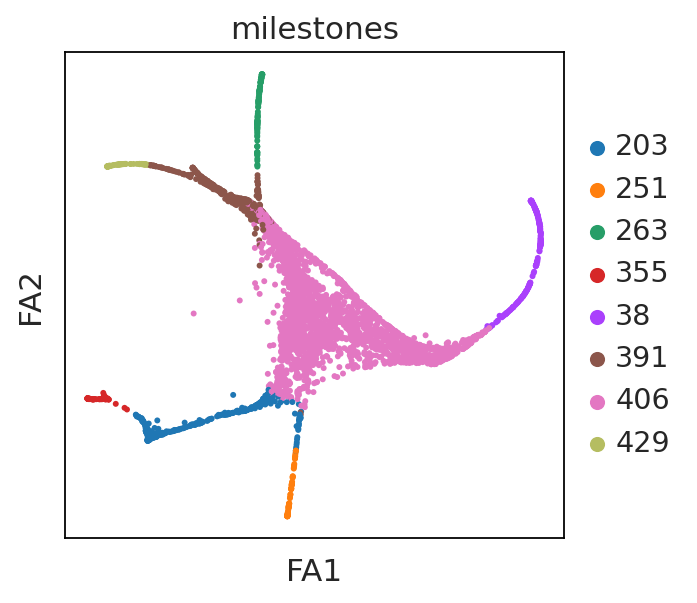

In [88]:
sc.pl.draw_graph(adata,color="cl")
sc.pl.draw_graph(adata,color="milestones")

In [89]:
scf.tl.rename_milestones(adata,["Neu vs Oligo","Neuronal","Unknown","Oligo","Prognitors","BifB","BifA","Astro"])

In [90]:
adata.write("adata_tree.h5ad")

In [1]:
sc.tl.ra

NameError: name 'sc' is not defined